# Imports


In [0]:
from keras.datasets import cifar10
(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()

Using TensorFlow backend.


In [0]:
!pip install opencv-contrib-python==3.4.2.17

In [1]:
import cv2
import pickle
import progressbar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# VLAD Implementation

In [0]:
class progressBar:
    def __init__(self):
            self.bar = progressbar.ProgressBar(maxval=1, \
                                  widgets=[progressbar.Bar('=','[',']'), ' ', progressbar.Percentage()])
            self.bar.start()
    
    def update(self,value):
        self.bar.update(value)

    def restart(self):
        self.bar.start()

In [0]:
class VLAD:

    def __init__(self,x_train,x_test):
        self.x_train = x_train
        self.x_test = x_test


    def cluster_formation(self,number_of_clusters):
        print("Performing KMeans Clustering","-"*(100-len("Performing KMeans Clustering")))
        keypoints = []
        counter=1
        bar = progressBar()
        for image in self.x_train :
            # image = self.resize2SquareKeepingAspectRation(image,150)
            bar.update(counter/len(list(self.x_train)))
            image = cv2.resize(image,(150,150))
            image =cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            surf = cv2.xfeatures2d.SURF_create()
            kp, descriptors = surf.detectAndCompute(image,None)
            keypoints.append(descriptors)
            counter+=1
        keypoints = np.concatenate(keypoints, axis=0)
        self.kmeans = KMeans(n_clusters = number_of_clusters).fit(keypoints)
        print("KMeans Clustering finished","-"*(100-len("KMeans Clustering finished")))
        return self.kmeans
    
    def vlad(self,descriptors,number_of_clusters):
        dist_sum = []
        for i in range(number_of_clusters):
            dist_sum.append(np.zeros(64))
        predict_kmeans = self.kmeans.predict(descriptors)
        cluster_centers = self.kmeans.cluster_centers_
        for i in range(len(descriptors)):
            dist_sum[predict_kmeans[i]] += (np.asarray(descriptors[i]) - cluster_centers[predict_kmeans[i]])
        dist_sum = np.asarray(dist_sum)
        V = dist_sum.flatten()
        V = V/np.sqrt(np.dot(V,V))
        return V

    
    def vlad_features(self,number_of_clusters):
        self.cluster_formation(number_of_clusters)
        print("Performing VLAD extraction","-"*(100-len("Performing VLAD extraction")))
        x_feat_train = []
        x_feat_test = []
        counter=1
        bar = progressBar()
        for n in range(2):
            if(n==0): dataset = self.x_train
            else: dataset = self.x_test
            for image in dataset:
                # image = self.resize2SquareKeepingAspectRation(image,150)
                bar.update(counter/(len(list(self.x_train))+len(list(self.x_test))))
                image = cv2.resize(image,(150,150))
                image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                surf = cv2.xfeatures2d.SURF_create()
                kp, descriptors = surf.detectAndCompute(image,None)
                V = self.vlad(descriptors,number_of_clusters)
                if(n==0): x_feat_train.append(V)
                else: x_feat_test.append(V)
                counter+=1
        print("VLAD extraction finished","-"*(100-len("VLAD extraction finished")))
        return (x_feat_train,x_feat_test)

    def resize2SquareKeepingAspectRation(self,img, size, interpolation = cv2.INTER_AREA):
        h, w = img.shape[:2]
        c = None if len(img.shape) < 3 else img.shape[2]
        if h == w: return cv2.resize(img, (size, size), interpolation)
        if h > w: dif = h
        else: dif = w
        x_pos = int((dif - w)/2.)
        y_pos = int((dif - h)/2.)
        if c is None:
            mask = np.zeros((dif, dif), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        else:
            mask = np.zeros((dif, dif, c), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        return cv2.resize(mask, (size, size), interpolation)    

# VLAD on CIFAR10

In [0]:
class CIFAR10:
    
        def __init__(self,xTrain,yTrain,xTest,yTest,number_of_clusters,vlad_done=0):
            self.xTrain = xTrain
            self.yTrain = yTrain
            self.xTest = xTest
            self.yTest = yTest
            print("Number of Training Images: {}".format(self.xTrain.shape[0]))
            print("Number of Testing Images: {}".format(self.xTest.shape[0]))
            if(vlad_done==0):
                self.vlad = VLAD(self.xTrain, self.xTest)
                (self.x_feat_train,self.x_feat_test) = self.vlad.vlad_features(number_of_clusters)
            else:
                self.x_feat_train = xTrain
                self.x_feat_test = xTest
        
        @staticmethod
        def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
            for i in range(1,2):
                with open(cifar10_dataset_folder_path + '/data_batch_' + str(i), mode='rb') as file:
                    # note the encoding type is 'latin1'
                    batch = pickle.load(file, encoding='latin1')
                    
                feature = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
                label = batch['labels']
                
                feature = np.array(feature)
                label = np.array(label)
                if(i==1):    
                    features = feature
                    labels = label
                else:
                    features = np.vstack((features,feature))
                    labels = np.concatenate((labels,label))
            return features, labels
        
        def random_forest(self):
            print("Training Model","-"*(100-len("Training Model")))

            # self.rf =KNeighborsClassifier(n_neighbors=5, metric='euclidean')
            self.rf = RandomForestClassifier(n_estimators = 1000)
            self.rf.fit(self.x_feat_train, self.yTrain)

            y_pred = self.rf.predict(self.x_feat_test)
            accuracy = accuracy_score(y_pred, self.yTest)
            print("Acuuracy of Model: {}".format(accuracy))
            return confusion_matrix(self.yTest, y_pred)
        
        def SVM(self):
            self.clf = svm.LinearSVC(multi_class='ovr')
            self.clf.fit(self.x_feat_train, self.yTrain)

            y_pred = self.clf.predict(self.x_feat_test)
            accuracy = accuracy_score(y_pred, self.yTest)
            print("Acuuracy of Model: {}".format(accuracy))
            return confusion_matrix(self.yTest, y_pred)

# Number of cluster detemination

In [0]:
# (x_train,y_train) = CIFAR10.load_cfar10_batch("../assignment2/data/cifar-10-batches-py",1)
# xTrain, xTest, yTrain, yTest = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)
# elbow = VLAD(xTrain,xTest)
# print("starting elbow","-"*70)
# for k in range(0,100,10):
#     km = elbow.cluster_formation(k)
#     Sum_of_squared_distances.append(km.inertia_)

In [0]:
# After performing the above, Sum_of_squared_distances came out to be
Sum_of_squared_distances = [76877.88404009117,66896.22038361382,61808.28464242649,58375.16939661905,56075.56547890369,54431.93220832537,53021.4142458,51868.198449324635,50868.11334349915]

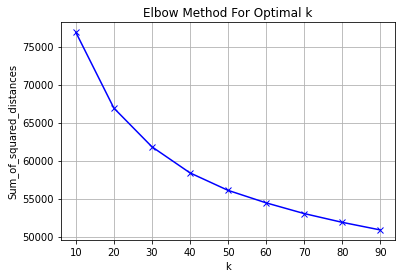

In [0]:
plt.plot(range(10,100,10), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

### Features vector after VLAD

In [0]:
x_feat_train = np.load('/content/drive/My Drive/VR/xtrain.npy')
y_train = np.load('/content/drive/My Drive/VR/ytrain.npy')
x_feat_test = np.load('/content/drive/My Drive/VR/xtest.npy')
y_test = np.load('/content/drive/My Drive/VR/ytest.npy')

# Data Visualization

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=10)
tsne_results = tsne.fit_transform(x_feat_test)

In [0]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = y_train

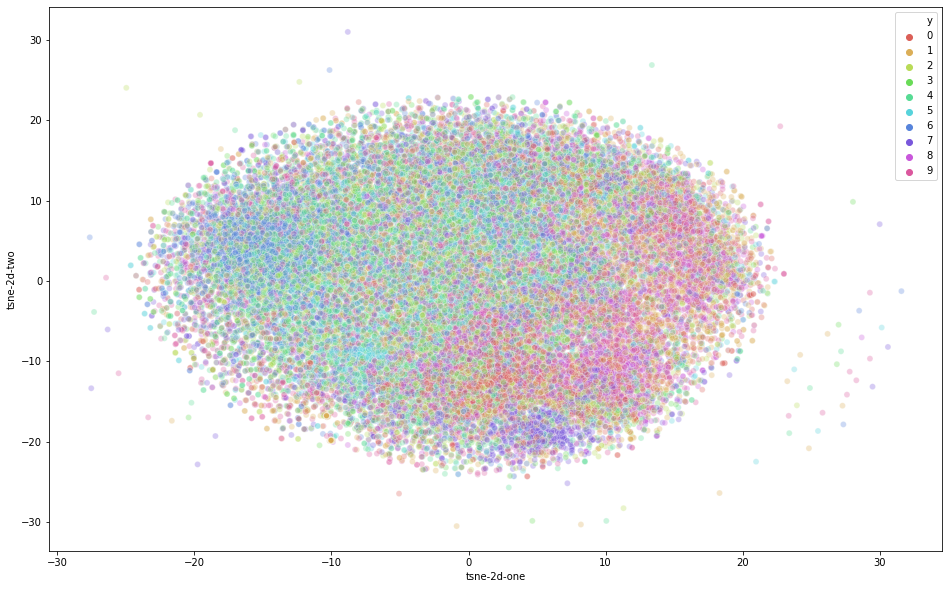

In [10]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig('tsne.png')

# Training Model on the VLAD features

In [0]:
x = CIFAR10(x_feat_train,y_train,x_feat_test,y_test,60,vlad_done=1)

Number of Training Images: 40000
Number of Testing Images: 10000


In [0]:
x.SVM()

Acuuracy of Model: 0.4359


array([[553,  55,  51,  18,  31,  37,  21,  53, 141,  44],
       [ 42, 546,  26,  39,  22,  31,  47,  24,  53, 156],
       [147,  47, 228,  79, 113,  89, 107,  88,  88,  30],
       [ 49,  63,  67, 209,  97, 164, 139,  86,  70,  86],
       [ 51,  30,  71,  66, 309,  59, 171, 124,  38,  48],
       [ 34,  48,  59,  89,  73, 394,  89, 100,  43,  87],
       [ 19,  44,  37,  52,  90,  54, 576,  30,  22,  29],
       [ 52,  53,  52,  53, 103,  74,  46, 441,  39,  86],
       [120,  76,  47,  29,  36,  36,  35,  44, 508,  58],
       [ 38, 116,  26,  52,  29,  26,  44,  55,  59, 595]])

# PCA Pre-processing

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler(feature_range=[0, 1])

scaler = StandardScaler()
x_feat_train = scaler.fit_transform(x_feat_train)
x_feat_test = scaler.transform(x_feat_test)

In [0]:
pca= PCA()
pca.fit(np.vstack((x_feat_train,x_feat_test)))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

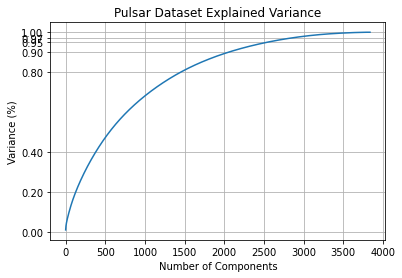

In [0]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.yticks([0,0.2,0.4,0.8,0.9,0.95,0.97,1])
plt.grid()
plt.show()

In [0]:
pca= PCA(0.95)
pca.fit(np.vstack((x_feat_train,x_feat_test)))

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
x_feat_train_red = pca.transform(x_feat_train)
x_feat_test_red = pca.transform(x_feat_test)

In [0]:
x_feat_train_red.shape

(40000, 2544)

In [0]:
x_feat_train.shape

(40000, 3840)

### Model Training after PCA

In [0]:
x1 = CIFAR10(x_feat_train_red,y_train,x_feat_test_red,y_test,60,vlad_done=1)

Number of Training Images: 40000
Number of Testing Images: 10000


In [0]:
x1.SVM()

Acuuracy of Model: 0.3281


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[444,  37,  88,  65,  57,  58,  28,  59, 131,  37],
       [ 58, 416,  56,  74,  37,  48,  51,  56,  65, 125],
       [134,  53, 197,  95, 119, 113, 101,  96,  75,  33],
       [ 53,  63, 125, 194, 112, 153, 121,  73,  67,  69],
       [ 56,  44, 111,  94, 216,  90, 124, 131,  40,  61],
       [ 53,  87,  82, 118,  91, 279, 100,  99,  45,  62],
       [ 27,  55, 103,  84,  85,  86, 397,  38,  29,  49],
       [ 60,  58,  82, 106,  83,  95,  46, 346,  38,  85],
       [140,  41,  78,  80,  69,  48,  45,  56, 380,  52],
       [ 49, 127,  47, 110,  48,  54,  56,  63,  74, 412]])

# LDA Pre-processing

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2500)
x_feat_train_lda = lda.fit_transform(x_feat_train, y_train)
x_feat_test_lda = lda.transform(x_feat_test)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3840, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [0]:
x_feat_train_lda.shape

(40000, 9)

### Model Training after LDA

In [0]:
x1 = CIFAR10(x_feat_train_lda,y_train,x_feat_test_lda,y_test,60,vlad_done=1)

Number of Training Images: 40000
Number of Testing Images: 10000


In [0]:
x1.SVM()

Acuuracy of Model: 0.4176


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[520,  51,  66,  28,  38,  40,  22,  44, 149,  46],
       [ 49, 511,  26,  46,  28,  36,  53,  39,  49, 149],
       [114,  53, 255,  98, 129,  80, 103,  83,  71,  30],
       [ 43,  64,  84, 229, 108, 147, 135,  87,  58,  75],
       [ 47,  31,  95,  84, 301,  60, 140, 119,  39,  51],
       [ 36,  53,  75, 124,  92, 351,  71,  86,  43,  85],
       [ 17,  44,  61,  78,  98,  61, 512,  35,  21,  26],
       [ 45,  59,  64,  71, 104,  82,  37, 425,  37,  75],
       [120,  74,  48,  36,  42,  41,  23,  50, 500,  55],
       [ 42, 119,  32,  48,  52,  31,  37,  59,  48, 572]])